<a href="https://colab.research.google.com/github/jxin11/natural-scene-image-classification/blob/main/Natural_Scene_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [162]:
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import ImageFont
from tensorflow import keras
from keras.utils import np_utils
from collections import Counter, OrderedDict
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Attention
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score

# Read & Store Images

In [2]:
!git clone https://github.com/jxin11/natural-scene-image-classification/

Cloning into 'natural-scene-image-classification'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 0), reused 3 (delta 0), pack-reused 4
Unpacking objects: 100% (7/7), done.


In [ ]:
!unzip /content/natural-scene-image-classification/src/nature.zip

## Train Set

In [58]:
# Train Set

SIZE = 128
train_images = []
train_labels = []

for folder_path in glob.glob("/content/nature/seg_train/seg_train/*"):
  label = folder_path.split("/")[-1]
  for img_path in glob.glob(folder_path + "/*.jpg"):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (SIZE, SIZE))   # Resize image
    train_images.append(img)
    train_labels.append(label)

In [59]:
print("Total no. of images: ", len(train_images))
print("Total no. of labels: ", len(train_labels))
print("Total no. of unique labels: ", Counter(train_labels))

Total no. of images:  2700
Total no. of labels:  2700
Total no. of unique labels:  Counter({'sea': 510, 'mountain': 510, 'street': 510, 'forest': 480, 'glacier': 480, 'buildings': 210})


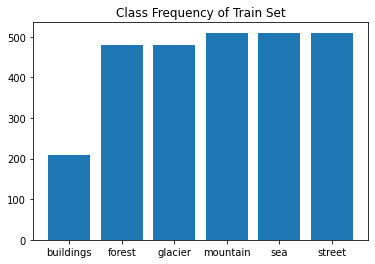


Train Set
buildings: 210 (7.78%)
forest: 480 (17.78%)
glacier: 480 (17.78%)
mountain: 510 (18.89%)
sea: 510 (18.89%)
street: 510 (18.89%)


In [60]:
# Plot Class Freqeuncy of Train Set
c_train = OrderedDict(sorted(Counter(train_labels).items()))
plt.bar(c_train.keys(), c_train.values())
plt.title("Class Frequency of Train Set")
plt.show()

print("\nTrain Set")
for i, v in enumerate(c_train):
  print(f"{v}: {c_train[v]} ({round(c_train[v]/sum(c_train.values())*100,2)}%)")

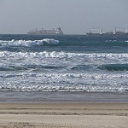

sea


In [62]:
cv2_imshow(train_images[0])
print(train_labels[0])

## Test Set

In [63]:
# Test Set

SIZE = 128
test_images = []
test_labels = []

for folder_path in glob.glob("/content/nature/seg_test/seg_test/*"):
  label = folder_path.split("/")[-1]
  for img_path in glob.glob(folder_path + "/*.jpg"):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (SIZE, SIZE))   # Resize image
    SIZE = 128
    test_images.append(img)
    test_labels.append(label)

In [64]:
print("Total no. of images: ", len(test_images))
print("Total no. of labels: ", len(test_labels))
print("Total no. of unique labels: ", Counter(test_labels))

Total no. of images:  536
Total no. of labels:  536
Total no. of unique labels:  Counter({'sea': 96, 'forest': 93, 'glacier': 93, 'mountain': 90, 'street': 90, 'buildings': 74})


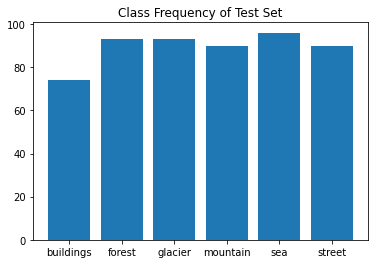


Test Set
buildings: 74 (13.81%)
forest: 93 (17.35%)
glacier: 93 (17.35%)
mountain: 90 (16.79%)
sea: 96 (17.91%)
street: 90 (16.79%)


In [65]:
# Plot Class Freqeuncy of Train Set
c_test = OrderedDict(sorted(Counter(test_labels).items()))
plt.bar(c_test.keys(), c_test.values())
plt.title("Class Frequency of Test Set")
plt.show()

print("\nTest Set")
for i, v in enumerate(c_test):
  print(f"{v}: {c_test[v]} ({round(c_test[v]/sum(c_test.values())*100,2)}%)")

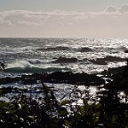

sea


In [66]:
cv2_imshow(test_images[0])
print(test_labels[0])

# Convert to Numpy Array

In [67]:
# Before conversion
print("X_train: ", "type-", type(train_images), "; size-", len(train_images))
print("y_train: ", "type-", type(train_labels), "; size-", len(train_labels))

X_train:  type- <class 'list'> ; size- 2700
y_train:  type- <class 'list'> ; size- 2700


In [68]:
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [69]:
# After conversion
print("X_train: ", "type-", type(train_images), "; size-", train_images.shape)
print("y_train: ", "type-", type(train_labels), "; size-", train_labels.shape)

X_train:  type- <class 'numpy.ndarray'> ; size- (2700, 128, 128, 3)
y_train:  type- <class 'numpy.ndarray'> ; size- (2700,)


# Label Encoding

In [72]:
le = preprocessing.LabelEncoder()
le.fit(train_labels)

LabelEncoder()

In [73]:
train_labels_encoded = le.transform(train_labels)
test_labels_encoded = le.transform(test_labels)

In [74]:
le.classes_

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

# One Hot Encoding

In [76]:
n_classes = len(le.classes_)

print("Shape before OHE: ", train_labels_encoded.shape)

train_labels_encoded = np_utils.to_categorical(train_labels_encoded,n_classes)
test_labels_encoded = np_utils.to_categorical(test_labels_encoded,n_classes)

print("Shape after OHE: ", train_labels_encoded.shape)

Shape before OHE:  (2700,)
Shape after OHE:  (2700, 6)


# Normalization

In [78]:
train_images, test_images = train_images/255.0, test_images/255.0

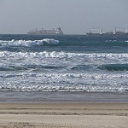

sea [0. 0. 0. 0. 1. 0.]


In [81]:
cv2_imshow(train_images[0]*255)
print(train_labels[0], train_labels_encoded[0])

# Model Training



In [194]:
model = Sequential()

model.add(Conv2D(input_shape=(SIZE,SIZE,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=n_classes, activation="softmax"))

In [195]:
tf.random.set_seed(5)  #2

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

early_stopping_monitor = EarlyStopping(patience=5)

history = model.fit(train_images, train_labels_encoded, batch_size=10, epochs=50,
                    validation_data=(test_images, test_labels_encoded),
                    callbacks=[early_stopping_monitor])

Epoch 1/50
270/270 [==============================] - 37s 69ms/step - loss: 1.7702 - accuracy: 0.1948 - val_loss: 1.7938 - val_accuracy: 0.1679
Epoch 2/50
270/270 [==============================] - 19s 69ms/step - loss: 1.7160 - accuracy: 0.2811 - val_loss: 1.7980 - val_accuracy: 0.1735
Epoch 3/50
270/270 [==============================] - 18s 68ms/step - loss: 1.7614 - accuracy: 0.1826 - val_loss: 1.8019 - val_accuracy: 0.1679
Epoch 4/50
270/270 [==============================] - 18s 67ms/step - loss: 1.7467 - accuracy: 0.2204 - val_loss: 1.7471 - val_accuracy: 0.3321
Epoch 5/50
270/270 [==============================] - 18s 68ms/step - loss: 1.4886 - accuracy: 0.4070 - val_loss: 1.3440 - val_accuracy: 0.5019
Epoch 6/50
270/270 [==============================] - 18s 68ms/step - loss: 1.2444 - accuracy: 0.5078 - val_loss: 1.3039 - val_accuracy: 0.4757
Epoch 7/50
270/270 [==============================] - 18s 68ms/step - loss: 1.1836 - accuracy: 0.5326 - val_loss: 1.2480 - val_accuracy:

# Evaluation

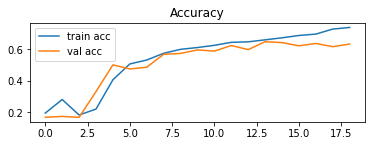

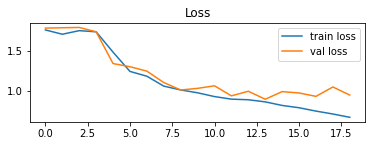

In [196]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Accuracy")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss")
plt.legend()
plt.show()

In [197]:
pred = [i.argmax() for i in model.predict(test_images)]
pred = le.inverse_transform(pred)

In [198]:
accuracy_score(test_labels, pred)

0.6343283582089553

**Optimizer**: SGD better than Adam & RMSprop

**Classifier**: <br>
Dense Layer x 1, 4096 neurons = 0.6063432835820896 <br>
Dense Layer x 1, 512 neurons = 0.6567164179104478  ✅ <br>  :
Dense Layer x 1, 256 neurons = 0.6343283582089553  <br>
Dense Layer x 1, 128 neurons = 0.628731343283582 <br>
Dense Layer x 2, 4096 neurons = 0.5802238805970149 <br>
Dense Layer x 2, 512 neurons = 0.6175373134328358  <br>
Dense Layer x 2, 256 neurons = 0.5783582089552238  <br>
Dense Layer x 2, 128 neurons = 0.6044776119402985 <br>

**Dropout**: <br>
Dropout 0.2 = 0.6343283582089553 🔽<br> 
Dropout 0.3 = 0.6511194029850746 🔽 <br>
Droupout 0.4 = 0.6194029850746269 🔽 <br>


In [199]:
le.classes_

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype='<U9')

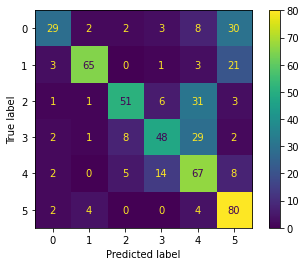

In [200]:
import sklearn.metrics
cm = sklearn.metrics.confusion_matrix(test_labels, pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Poor performance in predicting 'sea' and 'street'.